In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
! echo $PYTHONPATH

/env/python


In [0]:
import os
os.environ['PYTHONPATH'] += ":/content/drive/My Drive/Colab Notebooks/time-serie forecasting/"
! echo $PYTHONPATH

/env/python:/content/drive/My Drive/Colab Notebooks/time-serie forecasting/


**Import Libraries**

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from datetime import date
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import gc

import warnings
warnings.filterwarnings('ignore')

**Import Data**

In [0]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/time-serie forecasting/Metro_Interstate_Traffic_Volume.csv', infer_datetime_format=True)

In [0]:
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')

In [0]:
data = data.set_index(pd.DatetimeIndex(data['date_time']))


In [0]:
ts = data.traffic_volume['2018-03-30':'2018-09-29']

In [0]:
ts

date_time
2018-03-30 00:00:00     817
2018-03-30 01:00:00     413
2018-03-30 02:00:00     329
2018-03-30 03:00:00     359
2018-03-30 04:00:00     749
                       ... 
2018-09-29 19:00:00    3818
2018-09-29 20:00:00    3338
2018-09-29 21:00:00    2950
2018-09-29 22:00:00    2607
2018-09-29 23:00:00    3856
Name: traffic_volume, Length: 5430, dtype: int64

##Train/test Split

In [0]:
split_date = '2018-08-30'
ts_train = ts.loc[ts.index <= split_date].copy()
ts_test = ts.loc[ts.index > split_date].copy()

**Stationnarity**

In [0]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(168).mean()
    rolstd = timeseries.rolling(168).std()

    #Plot rolling statistics:
    plt.figure(figsize=(30,6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

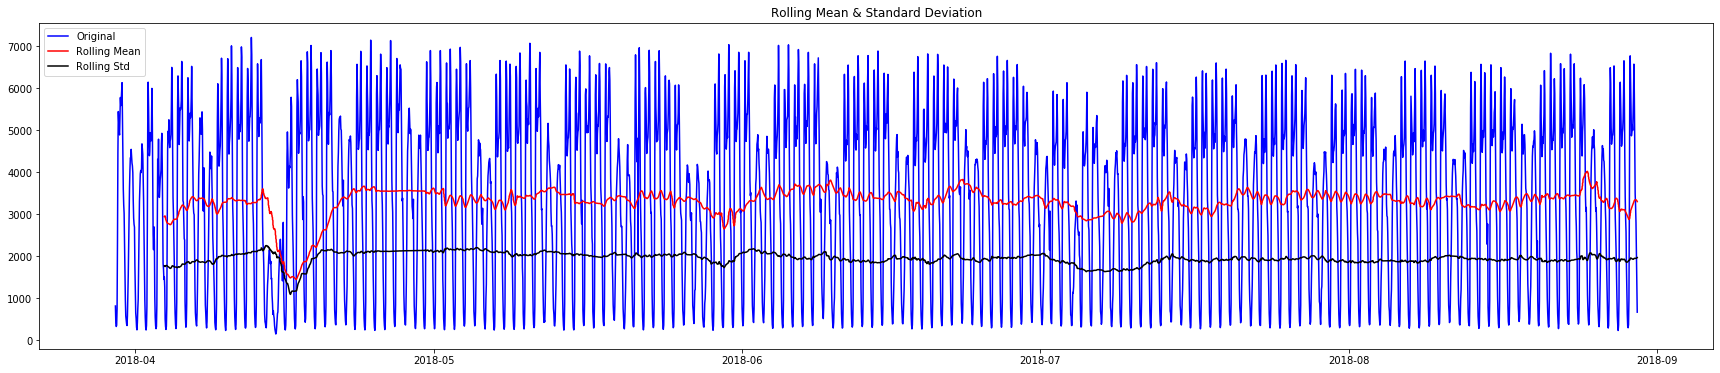

Results of Dickey-Fuller Test:
Test Statistic                -1.165918e+01
p-value                        1.952061e-21
#Lags Used                     2.400000e+01
Number of Observations Used    4.437000e+03
Critical Value (1%)           -3.431825e+00
Critical Value (5%)           -2.862192e+00
Critical Value (10%)          -2.567117e+00
dtype: float64


In [0]:
test_stationarity(ts_train)

**Building a model**

In [0]:
# ACF and PACF plots
lag = 168
lag_pacf = pacf(ts_train, nlags=lag, method='ols')
lag_acf = acf(ts_train, nlags=lag)

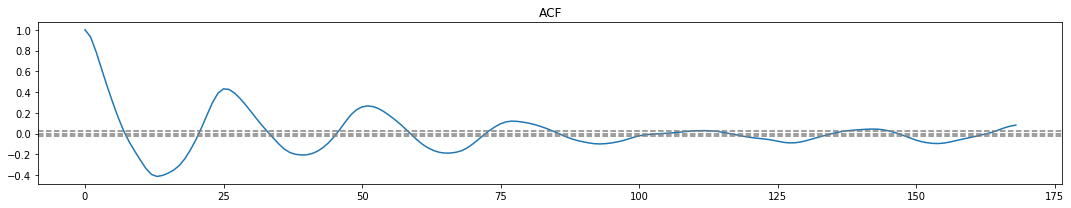

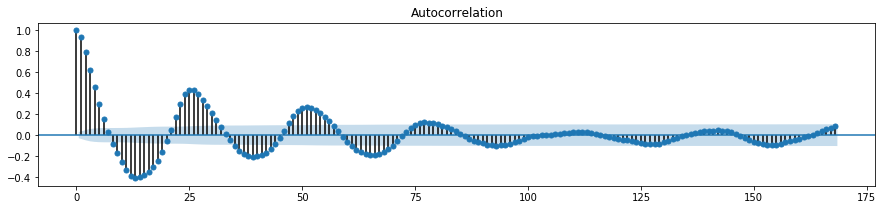

In [0]:
#Plot ACF: 
plt.figure(figsize=(15,3))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('ACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_acf(ts_train, ax=plt.gca(),lags=lag)
plt.show()

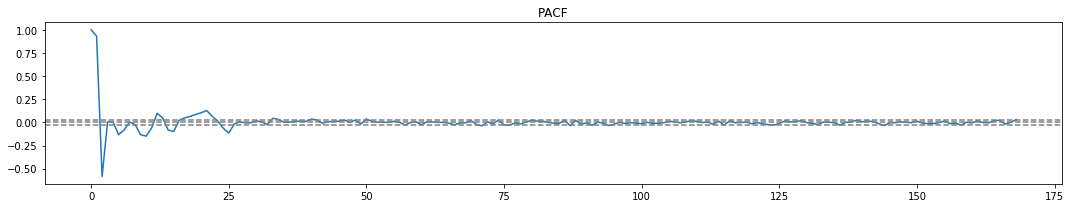

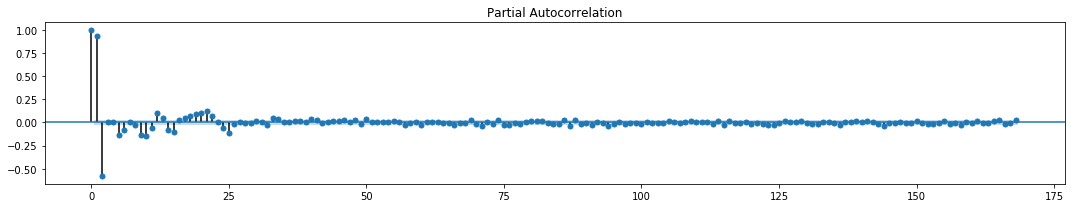

In [0]:
#Plot PACF:
plt.figure(figsize=(15,3))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('PACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_pacf(ts_train, ax=plt.gca(), lags=lag)
plt.tight_layout()
plt.show()

In [0]:
p=1
q=7
d=0

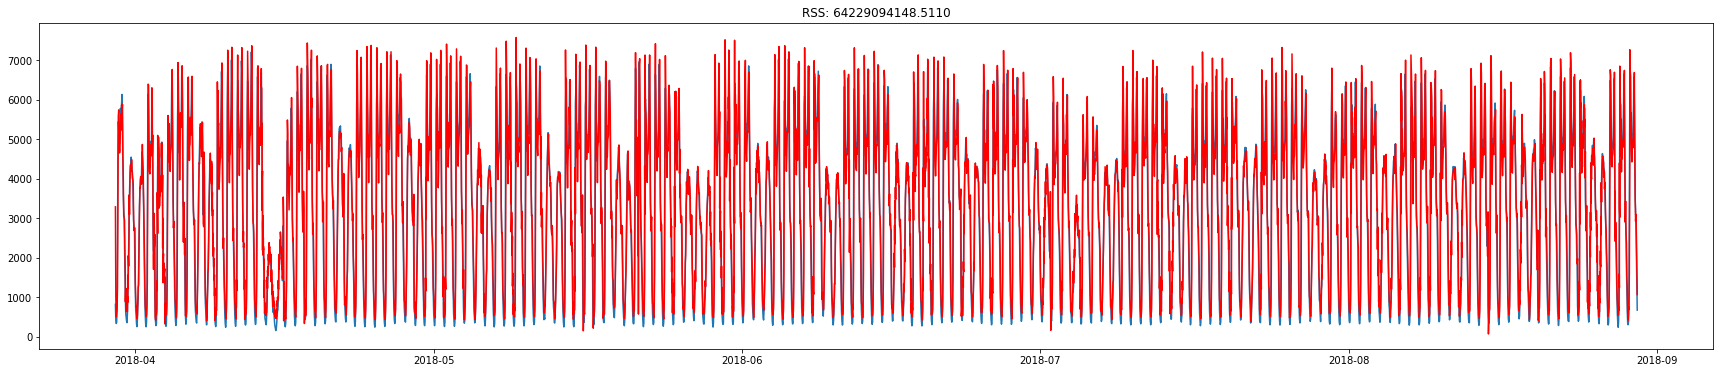

"\ndates = pd.date_range('2012-07-09','2012-07-30')\nseries = [43.,32.,63.,98.,65.,78.,23.,35.,78.,56.,45.,45.,56.,6.,63.,45.,64.,34.,76.,34.,14.,54.]\nres = pd.Series(series, index=dates)\nr = ARIMA(res,(1,2,0))\nr = r.fit()\npred = r.predict(start='2012-07-31', end='2012-08-31')\nprint(pred)\n"

In [0]:
# ARIMA
model = ARIMA(ts_train, order=(p, d, q))  
results_ARIMA = model.fit(disp=1)
plt.figure(figsize=(30,6))
plt.plot(ts_train)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues).dropna()**2))
plt.show()




'''
dates = pd.date_range('2012-07-09','2012-07-30')
series = [43.,32.,63.,98.,65.,78.,23.,35.,78.,56.,45.,45.,56.,6.,63.,45.,64.,34.,76.,34.,14.,54.]
res = pd.Series(series, index=dates)
r = ARIMA(res,(1,2,0))
r = r.fit()
pred = r.predict(start='2012-07-31', end='2012-08-31')
print(pred)
'''

In [0]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         traffic_volume   No. Observations:                 4462
Model:                     ARMA(1, 7)   Log Likelihood              -34747.137
Method:                       css-mle   S.D. of innovations            582.935
Date:                Wed, 20 Nov 2019   AIC                          69514.274
Time:                        15:33:18   BIC                          69578.308
Sample:                             0   HQIC                         69536.847
                                                                              
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3286.7837     83.010     39.595      0.000    3124.087    3449.481
ar.L1.traffic_volume     0.4695      0.067      7.042      0.000       0.339       0.600
ma.L1.traffic_volume     1.0082      0.065     15.471      0.000       0.880       1.136
ma.L2.traffic_volume     0.9336      0.098      9.542      0.000       0.742       1.125
ma.L3.traffic_volume     0.7181      0.112      6.413      0.000       0.499       0.938
ma.L4.traffic_volume     0.5498      0.102      5.370      0.000       0.349       0.750
ma.L5.traffic_volume     0.4252      0.078      5.465      0.000       0.273       0.578
ma.L6.traffic_volume     0.2906      0.049      5.918      0.000       0.194       0.387
ma.L7.traffic_volume     0.1245      0.025      5.008      0.000       0.076       0.173
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.1300           +0.0000j            2.1300            0.0000
MA.1            0.7990           -1.0139j            1.2909           -0.1438
MA.2            0.7990           +1.0139j            1.2909            0.1438
MA.3           -0.1857           -1.2778j            1.2912           -0.2730
MA.4           -0.1857           +1.2778j            1.2912            0.2730
MA.5           -1.0477           -0.9354j            1.4045           -0.3840
MA.6           -1.0477           +0.9354j            1.4045            0.3840
MA.7           -1.4657           -0.0000j            1.4657           -0.5000
-----------------------------------------------------------------------------
"""

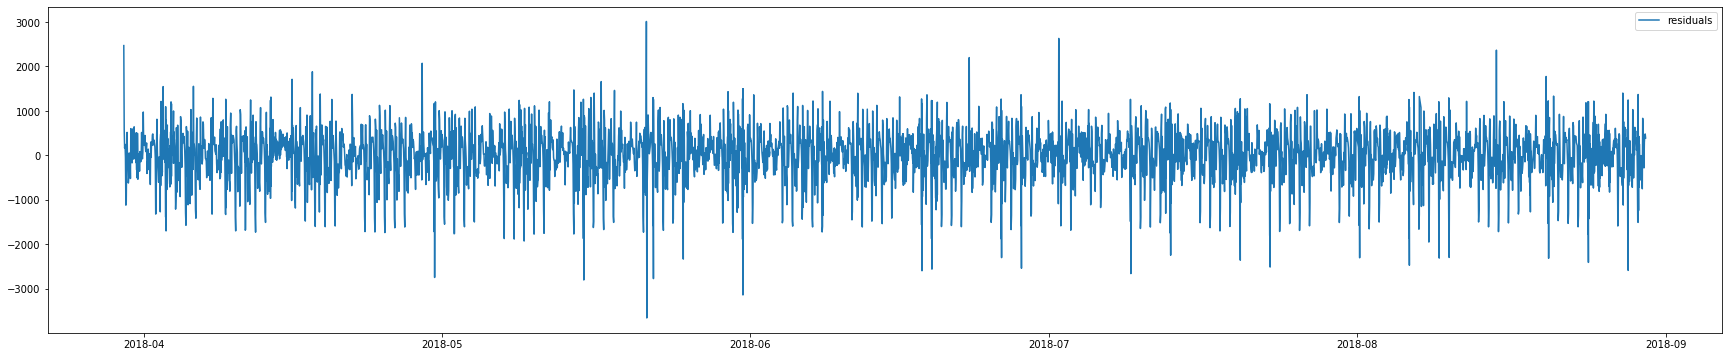

In [0]:
x = pd.DataFrame(results_ARIMA.fittedvalues)
x.columns = ['traffic_volume']
x = x.traffic_volume - ts_train
# x = x.cumsum()
plt.figure(figsize=(30,6))
plt.plot(x, label='residuals')
plt.legend(loc='best')
plt.show()

## Test ARIMA on testset

In [0]:
def StartARIMAForecasting(Actual, p, d, q):
	model = ARIMA(Actual, order=(p, d, q))
	model_fit = model.fit(disp=0)
	prediction = model_fit.forecast()[0]
	return prediction

In [0]:
#new arrays to store actual and predictions
Actual = [x for x in ts_train]
Predictions = list()

#in a for loop, predict values using ARIMA model
for timepoint in range(len(ts_test)):
	ActualValue =  ts_test[timepoint]
	#forcast value
	Prediction = StartARIMAForecasting(Actual, 3,1,0)    
	print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
	#add it in the list
	Predictions.append(Prediction)
	Actual.append(ActualValue)  
 
predictions=pd.DataFrame(Predictions).set_index(ts_test.index)

Actual=456.000000, Predicted=442.640649
Actual=326.000000, Predicted=455.373502
Actual=388.000000, Predicted=326.948919
Actual=388.000000, Predicted=454.245955
Actual=1008.000000, Predicted=398.208109
Actual=1008.000000, Predicted=1361.338932
Actual=3070.000000, Predicted=972.282941
Actual=5886.000000, Predicted=4199.754475
Actual=6466.000000, Predicted=7405.671304
Actual=6466.000000, Predicted=6420.273050
Actual=5995.000000, Predicted=6134.930552
Actual=5467.000000, Predicted=5660.530648
Actual=4911.000000, Predicted=5188.362769
Actual=5095.000000, Predicted=4669.236435
Actual=5308.000000, Predicted=5291.082298
Actual=5213.000000, Predicted=5480.552833
Actual=5680.000000, Predicted=5126.364211
Actual=6238.000000, Predicted=5935.006018
Actual=6453.000000, Predicted=6545.646591
Actual=5775.000000, Predicted=6496.469916
Actual=4531.000000, Predicted=5309.821492
Actual=3884.000000, Predicted=3825.278288
Actual=3332.000000, Predicted=3653.546987
Actual=3049.000000, Predicted=3181.395615
Ac

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
#Print MSE to see how good the model is
'''
print('Train Mean Absolute Error:', mean_absolute_error(train_y_i[0], ts_train_fcst[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(train_y_i[0], ts_train_fcst[:,0])))
print('Train Mean Absolute percentage Error:',mean_absolute_percentage_error(train_y_i[0], ts_train_fcst[:,0]))
'''
print('Test Mean Absolute Error:', mean_absolute_error(ts_test, predictions))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(ts_test, predictions)))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(ts_test, predictions[0]))

Test Mean Absolute Error: 429.13681841058
Test Root Mean Squared Error: 644.226714682445
Test Mean Absolute percentage Error: 18.999164546299067


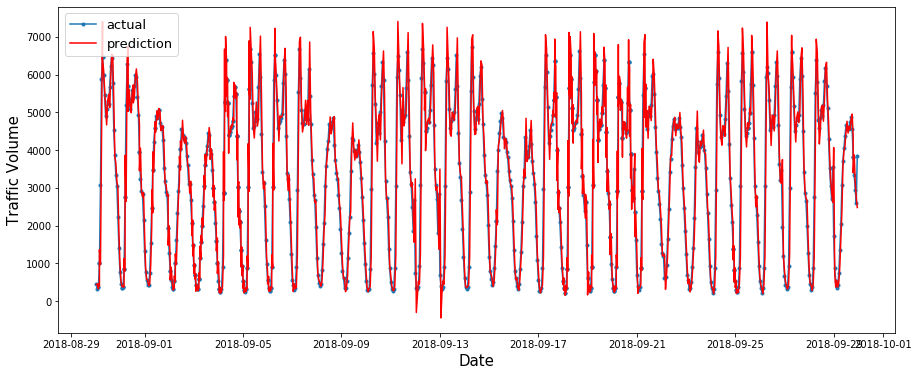

In [0]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, pd.DataFrame(ts_test), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(Predictions), 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

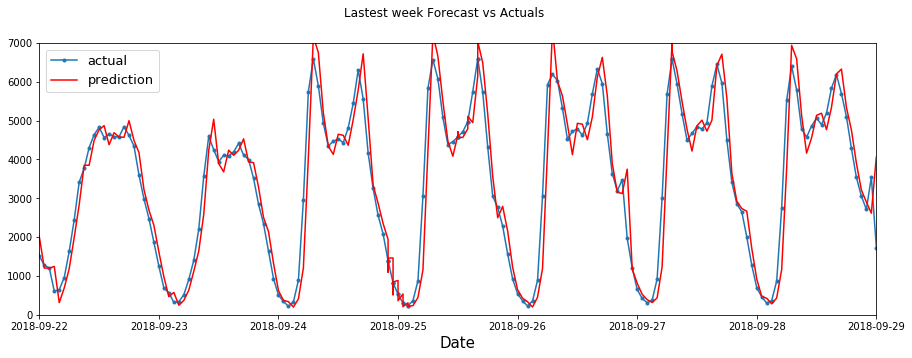

In [0]:
# zoom on lastest week)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, pd.DataFrame(ts_test), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(Predictions), 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,22), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 7000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')